<a href="https://colab.research.google.com/github/Nekose/Antibody_Analysis/blob/main/antibody_analysis_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Analysis of Antibody Testing
####*The following is based on a real-world problem using real data. Some of the information has been anonamized to maintain confidentialy and protect trade secrets.*

###As part of a product evaluation, an optical analizer produced quanititatve values equivalent to a color change after testing for the presence of an antibody in human sera. When compared against a calibration ladder, these color values can be converted to a standard unit and a clinical result determined.

###However, the resulting information quickly became overwhelming, as even the initial test required 30 samples analyzed for 17 antigens. To quickly interpret this information (and be better prepared for the next round of testing), I was tasked with writing a script to produce a visual representation of the results in an easy to digest form.

###This journal is an interactive recreation, and can be ran in real-time by clicking the arrow next to each code cell.

To begin, the following modules were required:

In [1]:
!pip install PyPDF2
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
import PyPDF2, os
import requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 2.5 MB/s eta 0:00:00


"Pandas" and "Numpy" were used for data management, while "Seaborn" provides a simple and easy to implement library for data visualiztion. Seaborn also allows for direct calls to the matplot library, and the "inline" magic function allows the figures to display directly in this notebook.

"PyPDF2" and "os" are used to condense multiple PDF pages into a single easy to read report. This was particulalry useful in my case given many of the people participating in the project did not have access to this workspace.

The "requests" module was not needed during the actual project, but allows for this demonstration to pull the relevant data files from my public github.

Once the appropraite modules were imported, I defined a series of functions to re-arrange the raw data, create a figure, and then segment the dataframe into chunks which display on a single 8 1/2 x 11 form.

In [2]:
'''
The first function, "convert_longform" takes the raw csv file output from the analizer and cleans the data. Columns were stripped, data types were converted to intergers,
and outliers were normalized to report as the max value. Because the "max" is determined per test event, this needed to be flexible and reassessed for each sample.

For each 'item' tested, the value was compared to the Cut Off (CO) value, and anything greater than CO was logged as "Positive".

Finally, a table in the form of a list of lists was created, ready to be imported directly into pandas.
'''

def convert_longform(csv):
    rawtable = []
    for row in open(csv):
        rawtable.append(row.split(","))
        longform = []
        for line in rawtable:
            sampleID = line[1]
            CO = int(line[47])
            max = int(line[53])
            results = line[6:42]
            for pos,item in enumerate(results):
                if pos == 1:
                    continue
                elif pos % 2 == 0:
                    continue
                if item[-1] == "*":
                    item = item[0:-1]
                elif item == '>max':
                    item = max
                if int(item) > max:
                    longform.append([sampleID,results[pos-1],max,CO,max,"Positive"])
                else:
                    result = "Negative"
                    if int(item)>CO:
                        result = "Positive"
                    longform.append([sampleID,results[pos-1],int(item),CO,max,result])
    return longform

'''
From there, we import the raw data into a Pandas DataFrame using the above function to prepare the data.
'''

! curl https://raw.githubusercontent.com/Nekose/Antibody_Analysis/main/antibody_data.tsv -o antibody_data.csv
df = pd.DataFrame(convert_longform('antibody_data.csv'),columns = ['SampleID',"Antibody","Value","Pos_Cutoff","Max","Result"])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8441  100  8441    0     0  36009      0 --:--:-- --:--:-- --:--:-- 36072


In [3]:
'''
Next, I created a function that uses Seaborn's FacetGrid to arrange a series of subplots into a larger figure.

Each subplot would be for a specific patient/sample (col="SampleID").
For ease of reading, I wanted the positive and negative bars to be different colors (hue="Result").
For the individual barplots, I wanted the order of antigens to be the same across all samples (order = ["Mi-2","Ku",...]),
Lastly, I wanted an easy visual guide to see how close a sample was to the cutoff, or how close it was to reaching the max recording value. The blue and red axes lines allowed for this.
Once the figure is created, it is saved as a unique PDF.
'''

def create_fig(df,columns,figheight,figaspect,name):
    g = sns.FacetGrid(df, col="SampleID",hue="Result",col_wrap=columns, height=figheight, aspect=figaspect,sharex=False,sharey=False)
    g.map(sns.barplot,"Value","Antibody",order=["Mi-2","Ku","U1-snRNP","CENP-B","Nucleosome","Histone","dsDNA",
                                                "Jo-1","Scl-70","Sm","P0","PCNA","La/SS-B","Ro/SS-A 52","Ro/SS-A 60","AMA-M2","PM/Scl-100"])

    cutoffs = df["Pos_Cutoff"][::17]
    maxes = df["Max"][::17]
    for axes,co,maxscale in zip(g.axes,cutoffs,maxes):
        axes.axvline(co,ls='--',color="blue")
        axes.axvline(maxscale,color="red")
    g.savefig(f'{name}.pdf')

In [4]:
'''
Finally, for the sake of making each facetgrid fit nicely onto a 8 1/2 x 11 sheet, I created a function to split a dataframe into smaller chunks, which can then be fed into the create_fig
function. This choice was made near the end of design, as key decision makers in the project could not easily access the google colab and required printed copies.

Although this does decrease the efficiency of the script (every 16 samples creates a new dataframe to be processed), computational complexity was not a significant concern given
the relatively small number of samples and low thoroughput of the optical analyzer.
'''

def split_dataframe(df,number_of_samples):
    returnlist = []
    current_step = 0
    for next_step in range(0,(len(df))+1,17*number_of_samples):
        subdata = df.iloc[current_step:next_step]
        current_step = next_step
        returnlist.append(subdata)
    return returnlist[1:]

After the above functions were defined, I immediatly called them. A list of dataframes was created using the split_dataframe() function, and each dataframe was called by the create_fig() function. This saves a series of PDF's to the current working directory. It also displays the same infromation within this notebook.

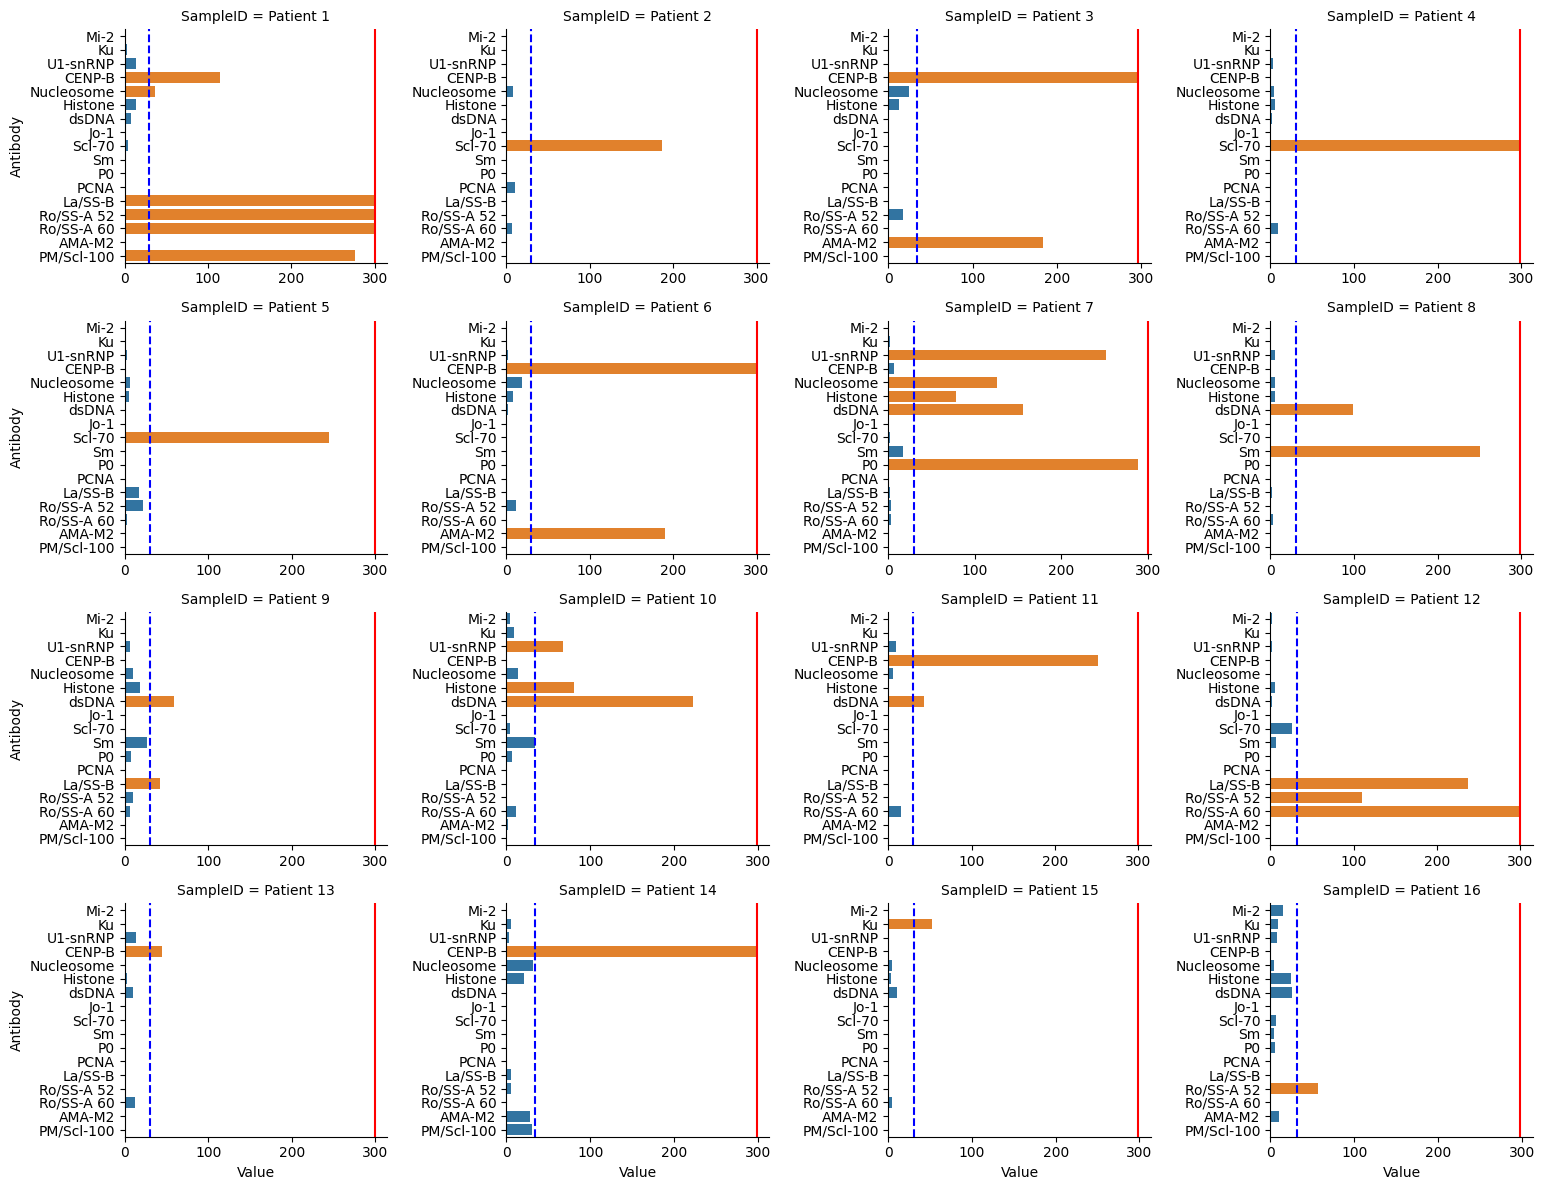

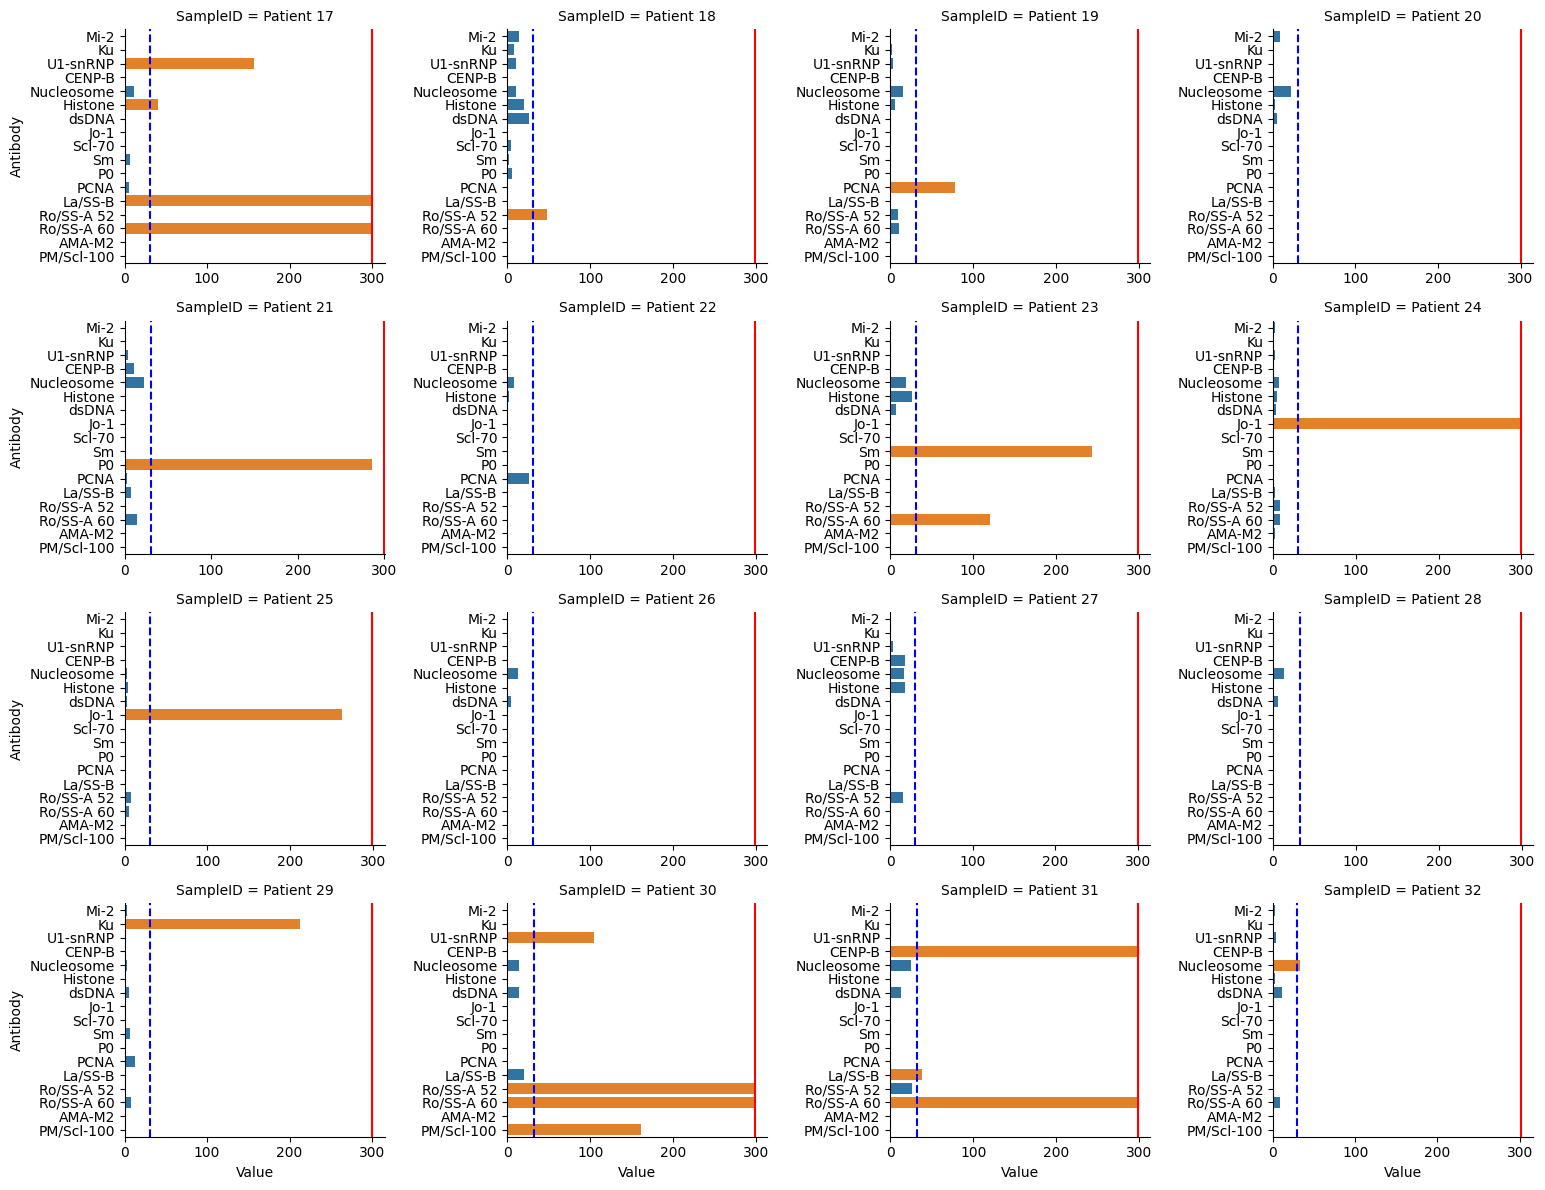

In [5]:
dataframeslist = split_dataframe(df,16)
for pos,element in enumerate(dataframeslist):
    create_fig(element,4,3,11/8.5,f'page_{str(pos)}_temp')

At the very end, a final call to the PyPDF2 module can stitch these bitesize PDF's into one continuous PDF report, all easily formated to print on standard paper. A quick import and call to the files builtin for google.colab allows us to quick download the file.

In [6]:
merger = PyPDF2.PdfMerger()
filelist = [x for x in os.listdir(os.getcwd()) if x.endswith("temp.pdf")]
for file in filelist:
    merger.append(file)
merger.write("Output.pdf")

In [8]:
from google.colab import files
files.download('Output.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>